Generation 0: Best Distance = 34.64472867438637
Generation 1: Best Distance = 34.64472867438637
Generation 2: Best Distance = 34.64472867438637
Generation 3: Best Distance = 34.64472867438637
Generation 4: Best Distance = 34.64472867438637
Generation 5: Best Distance = 34.64472867438637
Generation 6: Best Distance = 34.64472867438637
Generation 7: Best Distance = 34.64472867438637
Generation 8: Best Distance = 34.64472867438637
Generation 9: Best Distance = 34.64472867438637


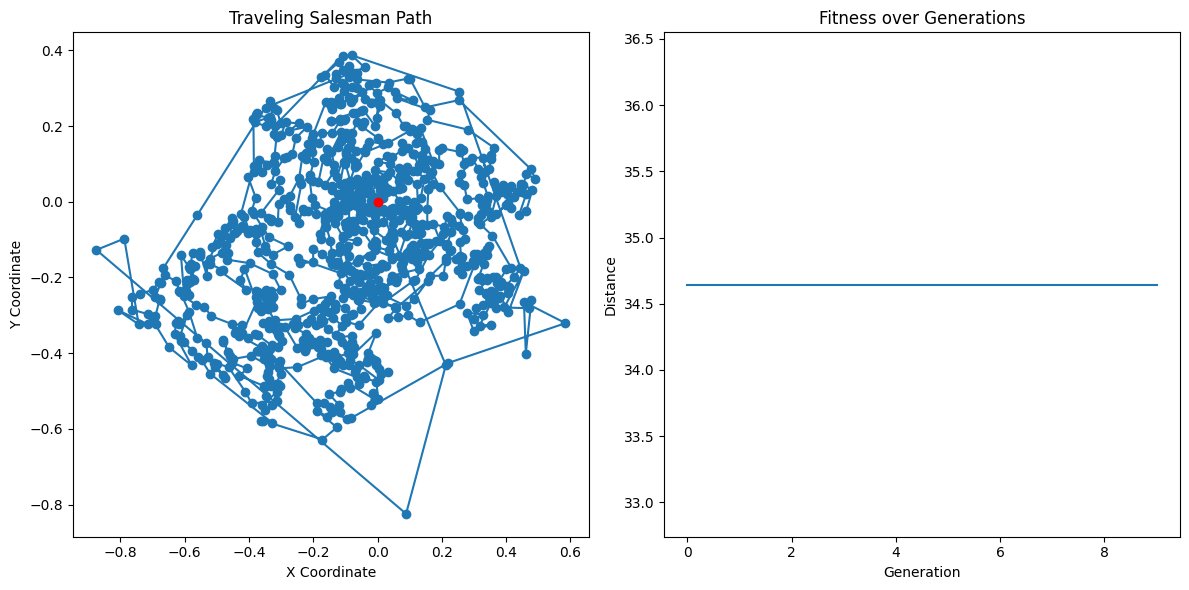

In [4]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math

class City:
    def __init__(self, x, y):
        self.x = x  # 도시의 x 좌표
        self.y = y  # 도시의 y 좌표

    def distance(self, city):
        xDistance = abs(self.x - city.x)  # 두 도시 간의 x축 거리
        yDistance = abs(self.y - city.y)  # 두 도시 간의 y축 거리
        return np.sqrt((xDistance ** 2) + (yDistance ** 2))  # 유클리드 거리 계산

    def __repr__(self):
        return f"({self.x}, {self.y})"  # 객체를 문자열로 나타냄, 도시 좌표 출력
    
    def read_cities(file_name):
        cities = []
        with open(file_name, mode='r', newline='') as tsp:
            reader = csv.reader(tsp)
            first_city = next(reader)  # 첫 번째 행을 읽어서 시작 도시로 사용
            start_city = City(float(first_city[0]), float(first_city[1]))
            cities.append(start_city)  # 시작 도시를 도시 목록에 추가
            for row in reader:
                if row:
                    x, y = map(float, row)
                    cities.append(City(x, y))
        return cities

class Distance:
    # 경로의 총 거리를 계산
    # 순환 경로 총 거리 계산
    def total_distance(route):
        return sum(route[i].distance(route[(i + 1) % len(route)]) for i in range(len(route)))

# 트리 탐색 기법
class AStar:

    def aStar(cities): 
        start = cities[0]
        visited = [start]
        route = [start]
    
        while len(visited) != len(cities):
            min_f_value = math.inf
            min_index = 0
            for j in range(1, len(cities)):
                if cities[j] not in visited:
                    heuristic = route[0].distance(cities[j]) # 목표까지의 휴리스틱 거리 계산
                    distance = route[-1].distance(cities[j]) # 현재 경로의 마지막 도시에서 해당 도시까지 계산
                    f_value = distance + heuristic # f 값 계산
                    if f_value < min_f_value: # 최소 f값 구하기
                        if (random.random() < 0.7): # 다양성을 위해 랜덤으로 선택
                            min_f_value = f_value   
                            min_index = j
            
            if (min_index != 0):
                visited.append(cities[min_index])
                route.append(cities[min_index])
        return route
    

# 트리 탐색 기법
class Greedy:
    
    def greedy(start_city, cities, k=5):
        route = [start_city]
        unvisited = set(cities) - {start_city}

        current_city = start_city
        while unvisited:
            # 현재 도시에서 가장 가까운 k개 도시를 후보로 선정, 다양성을 위해
            if len(unvisited) > k:
                candidates = sorted(unvisited, key=lambda city: current_city.distance(city))[:k]
                next_city = random.choice(candidates)
            else:   
                next_city = min(unvisited, key=lambda city: current_city.distance(city))
        
            route.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
        return route

class Select:

    def tournament_selection(population):
        tournament = random.sample(population, int(len(population) * 0.2))
        
        t = random.random()
        #if t < 0.8:
            # 토너먼트 내에서 가장 적합도가 높은(거리가 가장 짧은) 개체를 선택
        fittest = min(tournament, key=Distance.total_distance)
        return fittest
        #else:
            # 토너먼트 내에서 가장 적합도가 낮은(거리가 가장 긴) 개체를 선택, 다양성 위해
        #    return weakest
    
    def roulette_wheel_selection(population):
        fitness_values = [1 / Distance.total_distance(route) for route in population]
        total_fitness = sum(fitness_values)
        probabilities = [fitness / total_fitness for fitness in fitness_values]
        return random.choices(population, weights=probabilities)[0]
    
    def ranking_selection(population):
        fitness_result = []
        for i in range(len(population)):
          fitness_result.append([i, (Distance.total_distance(population[i]))])

        fitness_result = sorted(fitness_result, key=lambda x: x[1])

        max_fit = max(fitness_result, key=lambda x: x[1])[1]
        min_fit = min(fitness_result, key=lambda x: x[1])[1]

        n = len(fitness_result)
        list_idx_fit = []

        for i, (init_idx, _) in enumerate(fitness_result):
          fitness = max_fit + (i - 1) * (min_fit - max_fit) / n
          list_idx_fit.append([init_idx, fitness])

        total_fitness = 0
        for _, fitness in list_idx_fit:
           total_fitness += fitness

        prob = []
        for i, fitness in list_idx_fit:
           prob.append([i, fitness / total_fitness])
        idx = random.choices(range(len(population)), weights=[p[1] for p in prob])[0]
        return population[idx]
    
    def calculate_shared_fitness(chromosome, population, shared_coefficient=2.0):
        total_difference = sum(Cross.chromosome_difference(chromosome, other_chromosome) for other_chromosome in population)
        if total_difference == 0:
            return 0  # 자기 자신과의 거리는 0
        shared_fitness = len(population) /(shared_coefficient* total_difference)
        return shared_fitness

    def fitness_selection(population, shared_coefficient=2.0):
        shared_fitnesses = []
        for chromosome in population:
            shared_fitness = Select.calculate_shared_fitness(chromosome, population, shared_coefficient)
            shared_fitnesses.append(shared_fitness)

        total_shared_fitness = sum(shared_fitnesses)
        probabilities = [shared_fitness / total_shared_fitness for shared_fitness in shared_fitnesses]

        return random.choices(population, probabilities)[0]


class Cross:

    def crossover(parent1, parent2, fixed_start):
        child = [fixed_start]
        geneA = int(random.random() * (len(parent1) - 1)) + 1
        geneB = int(random.random() * (len(parent1) - 1)) + 1

        startGene, endGene = min(geneA, geneB), max(geneA, geneB)

        childP1 = [parent1[i] for i in range(startGene, endGene) if parent1[i] != fixed_start]
        childP2 = [item for item in parent2 if item not in childP1 and item != fixed_start]
        child += childP1 + childP2
        return child
    
    #choromosome difference
    def chromosome_difference(chromosome1, chromosome2):
        return sum(1 for gene1, gene2 in zip(chromosome1, chromosome2) if gene1 != gene2)

class Mutate:

    def mutate(route, fixed_start):
    # 첫 번째 도시를 제외한 나머지 도시의 인덱스 추출
        idx_range = list(range(1, len(route)))
        swapIdx1, swapIdx2 = random.sample(idx_range, 2)
        route[swapIdx1], route[swapIdx2] = route[swapIdx2], route[swapIdx1]

class TotalGA:

    def genetic_algorithm(cities, generations=300, population_size=200, mutation_rate=0.4):
        # 첫 도시 고정
        fixed_start = cities[0]
        population = []

        fitness_history = []

         # astar 알고리즘
        for i in range(0, population_size):
            population.append(AStar.aStar(cities))
        
        ''' #그리디 알고리즘
        for _ in range(population_size):
            new_route = Greedy.greedy(fixed_start, cities, k=10)
            population.append(new_route)
        '''

        '''# 랜덤 선택 알고리즘
        rest_cities = cities[1:]
        # 초기 세대 생성, 첫 도시를 제외한 나머지 도시를 셔플
        population = [[fixed_start] + random.sample(rest_cities, len(rest_cities)) for _ in range(population_size)]
        '''

        for generation in range(generations):
            # 적합도에 따라 정렬
            population.sort(key=Distance.total_distance)
            fitness_history.append(Distance.total_distance(population[0]))

            print(f"Generation {generation}: Best Distance = {fitness_history[-1]}")
        
            new_population = population[:2]  # 엘리트 보존
            while len(new_population) < population_size:

                #토너먼트 선택
                parent1 = Select.tournament_selection(population)
                parent2 = Select.tournament_selection(population)

                #룰렛 휠 선택
                #parent1 = Select.roulette_wheel_selection(population)
                #parent2 = Select.roulette_wheel_selection(population)

                #랭킹 선택
                #parent1 = Select.ranking_selection(population)
                #parent2 = Select.ranking_selection(population)

                #공유 기반 선택
                #parent1 = Select.fitness_selection(population)
                #parent2 = Select.fitness_selection(population)

                child = Cross.crossover(parent1, parent2, fixed_start)
                mutation_rate = (generation+ 1) / (generations * 2) # 세대 수에 따른 돌연변이 확률 증가
                if random.random() < mutation_rate:
                    Mutate.mutate(child, fixed_start)
                new_population.append(child)
            population = new_population

        return population[0], fitness_history


class Result:

    def plot_route_and_fitness(route, fitness_history):
        plt.figure(figsize=(12, 6))
    
        plt.subplot(1, 2, 1)
        x = [city.x for city in route]
        y = [city.y for city in route]
        plt.plot(x + [x[0]], y + [y[0]], 'o-', label='Route')
        plt.plot(x[0], y[0], 'ro')
        plt.title("Traveling Salesman Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
    
        plt.subplot(1, 2, 2)
        plt.plot(range(len(fitness_history)), fitness_history)
        plt.title("Fitness over Generations")
        plt.ylabel('Distance')
        plt.xlabel('Generation')
    
        plt.tight_layout()
        plt.show()

    def save_to_csv(original_cities, route, filename="final_route.csv"):
        # 방문 순서를 저장하기 위한 사전 생성
        city_order = {city: index + 1 for index, city in enumerate(route)}
    
        with open(filename, "w", newline='') as f:
            writer = csv.writer(f)
            for index, city in enumerate(original_cities):
                visit_order = city_order.get(city, -1)  # 해당 도시가 방문된 순서
                writer.writerow([visit_order - 1])


def main():
    # 파일 읽기 및 유전 알고리즘 실행
    cities = City.read_cities('2024_AI_TSP.csv')
    best_route, fitness_history = TotalGA.genetic_algorithm(cities, generations=300, population_size=200)
    Result.plot_route_and_fitness(best_route, fitness_history)
    Result.save_to_csv(cities, best_route)
    

if __name__ == "__main__":
    main()